# Project Neural Network of Statistical Methods for Machine Learning

### Installation of packages and API configuration

In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorflow
#Keras for the hyperparameters tuning
!pip install -q -U keras-tuner

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Import modules

In [9]:
import os, subprocess
import kaggle

import pandas as pd
import numpy as np

#Tensorflow modules
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import keras.utils
from tensorflow.keras.applications.resnet50 import ResNet50
#Keras Hyperparameters tuning
import keras_tuner as kt

# Matplotlib modules
import matplotlib.pyplot as plt

### Download and access to the muffins and Chihuahuas data

In [7]:
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

 97% 459M/474M [00:07<00:00, 73.2MB/s]
100% 474M/474M [00:07<00:00, 66.0MB/s]


In [ ]:
!unzip /content/muffin-vs-chihuahua-image-classification.zip

In [8]:
test_set = '/content/test'
training_set = '/content/train'

## Pre-processing

Pre-processing images from the training and test datasets. Resizing the image color mode, the size of the image and of the batch.

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
COLOR_MODE = 'rgb'
LABEL_MODE = 'binary'

print("Training set: ")
train_img = tf.keras.utils.image_dataset_from_directory(
    training_set,
    validation_split=0.2,
    subset="training",
    seed=100,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)
print("Validation set: ")
val_img = tf.keras.utils.image_dataset_from_directory(
    training_set,
    validation_split=0.2,
    subset="validation",
    seed=100,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)
print("Test set: ")
test_img = tf.keras.utils.image_dataset_from_directory(
    test_set,
    seed=100,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Training set: 
Found 4733 files belonging to 2 classes.
Using 3787 files for training.
Validation set: 
Found 4733 files belonging to 2 classes.
Using 946 files for validation.
Test set: 
Found 1184 files belonging to 2 classes.


In [12]:
print(train_img.class_names)

['chihuahua', 'muffin']


In [13]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_img).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_img).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_img).numpy())

Number of training batches: 119
Number of validation batches: 30
Number of test batches: 37


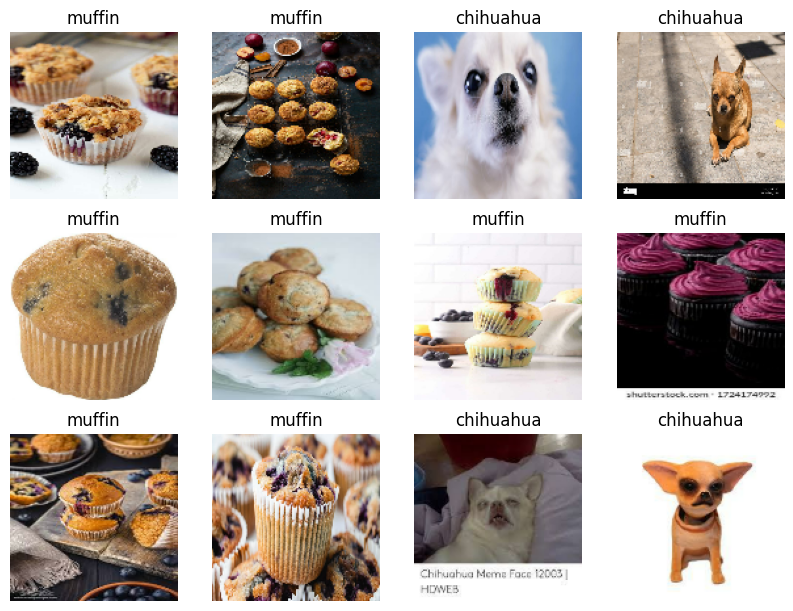

In [14]:
image_batch, label_batch = next(iter(train_img))

plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(train_img.class_names[int(label)])
    plt.axis("off")

Methods to allow the dataset to be executed correctly during the training of the models

In [15]:
# Dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_img.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_img.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_img.prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image, label in train_dataset.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Normalize the Dataset in the range [0, 1]

In [17]:
def normalize_image(image, label):
    image = image / 255.0
    return image, label

train_normalized = train_dataset.map(normalize_image)
val_normalized = val_dataset.map(normalize_image)
test_normalized = test_dataset.map(normalize_image)

## Experiments with network architectures and training hyperparameters

### Multi Layer Perceptron (MLP)

Define the First MLP model

In [ ]:
model_mlp1 = tf.keras.Sequential()
model_mlp1.add(layers.Flatten(input_shape=(128, 128, 3), name="input"))
model_mlp1.add(layers.Dense(256, activation='relu', name='hidden1'))
model_mlp1.add(layers.Dense(128, activation='relu', name='hidden2'))
model_mlp1.add(layers.Dense(1, activation='sigmoid', name='output'))
model_mlp1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 49152)             0         
                                                                 
 hidden1 (Dense)             (None, 256)               12583168  
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 12,616,193
Trainable params: 12,616,193
Non-trainable params: 0
_________________________________________________________________


Plotting the model schema

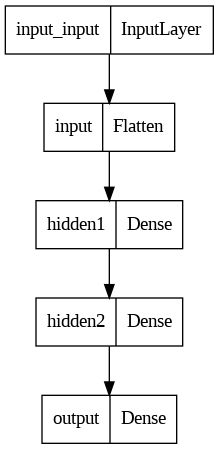

In [ ]:
keras.utils.plot_model(model_mlp1, 'model_mlp1.png')

Compile and fitting the model

In [ ]:
model_mlp1.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
history_mlp1 = model_mlp1.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 47s 377ms/step - loss: 3.5447 - accuracy: 0.5630 - val_loss: 0.9135 - val_accuracy: 0.6089
Epoch 2/10
119/119 [==============================] - 50s 416ms/step - loss: 0.6867 - accuracy: 0.6794 - val_loss: 0.5570 - val_accuracy: 0.7452
Epoch 3/10
119/119 [==============================] - 46s 378ms/step - loss: 0.5913 - accuracy: 0.7114 - val_loss: 0.5552 - val_accuracy: 0.7357
Epoch 4/10
119/119 [==============================] - 54s 443ms/step - loss: 0.6259 - accuracy: 0.7037 - val_loss: 0.5912 - val_accuracy: 0.7040
Epoch 5/10
119/119 [==============================] - 45s 364ms/step - loss: 0.5511 - accuracy: 0.7341 - val_loss: 0.5328 - val_accuracy: 0.7569
Epoch 6/10
119/119 [==============================] - 45s 371ms/step - loss: 0.4970 - accuracy: 0.7616 - val_loss: 0.5155 - val_accuracy: 0.7632
Epoch 7/10
119/119 [==============================] - 45s 358ms/step - loss: 0.4613 - accuracy: 0.7843 - val_loss: 0.5175 - val_ac

Plotting the loss and the accuracy

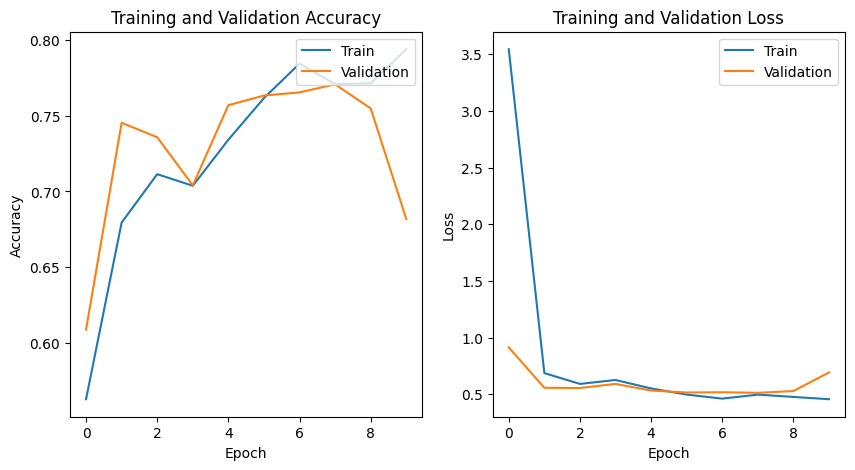

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mlp1.history['accuracy'])
plt.plot(history_mlp1.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp1.history['loss'])
plt.plot(history_mlp1.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_mlp1.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 7s 151ms/step - loss: 0.6749 - accuracy: 0.6833
Test Loss: 0.674851
Test Accuracy: 0.683277


Define the Second MLP model

In [ ]:
model_mlp2 = tf.keras.Sequential()
model_mlp2.add(layers.Flatten(input_shape=(128, 128, 3), name="input"))
model_mlp2.add(layers.Dense(256, activation='relu', name='hidden1'))
model_mlp2.add(layers.Dense(128, activation='relu', name='hidden2'))
model_mlp2.add(layers.Dense(64, activation='relu', name='hidden3'))
model_mlp2.add(layers.Dense(1, activation='sigmoid', name='output'))
model_mlp2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 49152)             0         
                                                                 
 hidden1 (Dense)             (None, 256)               12583168  
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 hidden3 (Dense)             (None, 64)                8256      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 12,624,385
Trainable params: 12,624,385
Non-trainable params: 0
_________________________________________________________________


Plotting the model schema

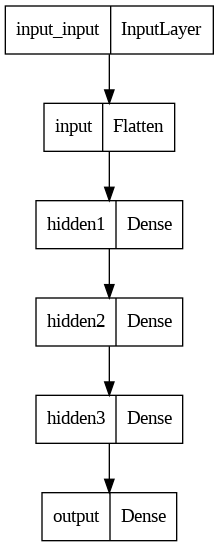

In [ ]:
keras.utils.plot_model(model_mlp2, 'model_mlp2.png')

Compile and fitting the model

In [ ]:
model_mlp2.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
history_mlp2 = model_mlp2.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 46s 369ms/step - loss: 2.0356 - accuracy: 0.5799 - val_loss: 0.7659 - val_accuracy: 0.5994
Epoch 2/10
119/119 [==============================] - 46s 377ms/step - loss: 0.6704 - accuracy: 0.6752 - val_loss: 1.0189 - val_accuracy: 0.5042
Epoch 3/10
119/119 [==============================] - 46s 377ms/step - loss: 0.6217 - accuracy: 0.6924 - val_loss: 0.5672 - val_accuracy: 0.7209
Epoch 4/10
119/119 [==============================] - 44s 363ms/step - loss: 0.5609 - accuracy: 0.7159 - val_loss: 0.6440 - val_accuracy: 0.6575
Epoch 5/10
119/119 [==============================] - 47s 383ms/step - loss: 0.6062 - accuracy: 0.7040 - val_loss: 0.5189 - val_accuracy: 0.7590
Epoch 6/10
119/119 [==============================] - 46s 380ms/step - loss: 0.4652 - accuracy: 0.7827 - val_loss: 0.5042 - val_accuracy: 0.7653
Epoch 7/10
119/119 [==============================] - 46s 380ms/step - loss: 0.4927 - accuracy: 0.7616 - val_loss: 0.5019 - val_ac

Plotting the loss and the accuracy

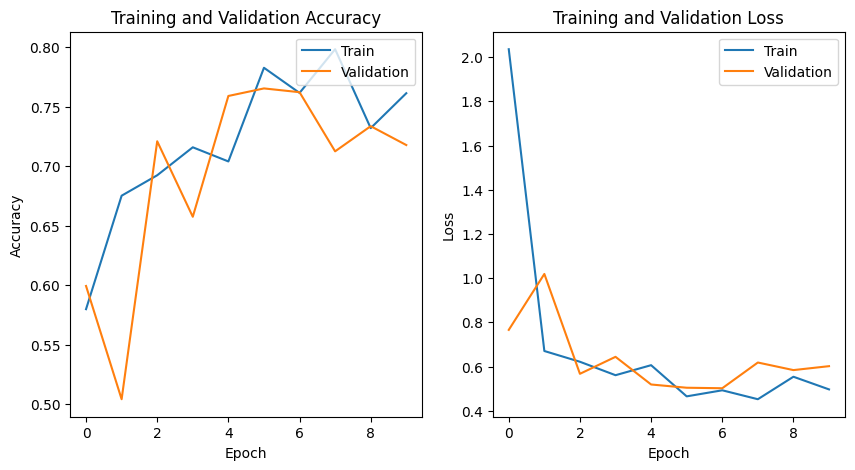

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mlp2.history['accuracy'])
plt.plot(history_mlp2.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp2.history['loss'])
plt.plot(history_mlp2.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_mlp2.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 7s 141ms/step - loss: 0.5782 - accuracy: 0.7213
Test Loss: 0.578183
Test Accuracy: 0.721284


Define the Third MLP model

In [ ]:
model_mlp3 = tf.keras.Sequential()
model_mlp3.add(layers.Flatten(input_shape=(128, 128, 3), name="input"))
model_mlp3.add(layers.Dense(256, activation='relu', name='hidden1'))
model_mlp3.add(layers.Dense(128, activation='relu', name='hidden2'))
model_mlp3.add(layers.Dense(64, activation='relu', name='hidden3'))
model_mlp3.add(layers.Dense(32, activation='relu', name='hidden4'))
model_mlp3.add(layers.Dense(1, activation='sigmoid', name='output'))
model_mlp3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 49152)             0         
                                                                 
 hidden1 (Dense)             (None, 256)               12583168  
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 hidden3 (Dense)             (None, 64)                8256      
                                                                 
 hidden4 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 12,626,433
Trainable params: 12,626,433


Plotting the model schema

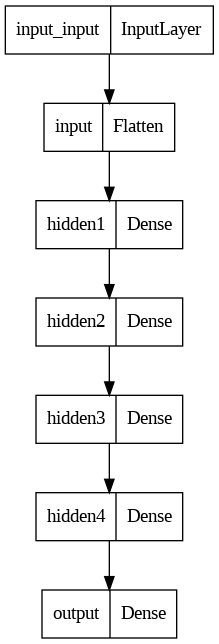

In [ ]:
keras.utils.plot_model(model_mlp3, 'model_mlp3.png')

Compile and fitting the model

In [ ]:
model_mlp3.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
history_mlp3 = model_mlp3.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 46s 354ms/step - loss: 1.3816 - accuracy: 0.5733 - val_loss: 1.0936 - val_accuracy: 0.5349
Epoch 2/10
119/119 [==============================] - 44s 363ms/step - loss: 0.6268 - accuracy: 0.6863 - val_loss: 0.5251 - val_accuracy: 0.7643
Epoch 3/10
119/119 [==============================] - 44s 360ms/step - loss: 0.5795 - accuracy: 0.7222 - val_loss: 0.9391 - val_accuracy: 0.5751
Epoch 4/10
119/119 [==============================] - 44s 362ms/step - loss: 0.6016 - accuracy: 0.7172 - val_loss: 0.9750 - val_accuracy: 0.5920
Epoch 5/10
119/119 [==============================] - 44s 362ms/step - loss: 0.5835 - accuracy: 0.7138 - val_loss: 0.8723 - val_accuracy: 0.5655
Epoch 6/10
119/119 [==============================] - 42s 345ms/step - loss: 0.4834 - accuracy: 0.7682 - val_loss: 0.4996 - val_accuracy: 0.7748
Epoch 7/10
119/119 [==============================] - 44s 359ms/step - loss: 0.4652 - accuracy: 0.7792 - val_loss: 0.5276 - val_ac

Plotting the loss and the accuracy

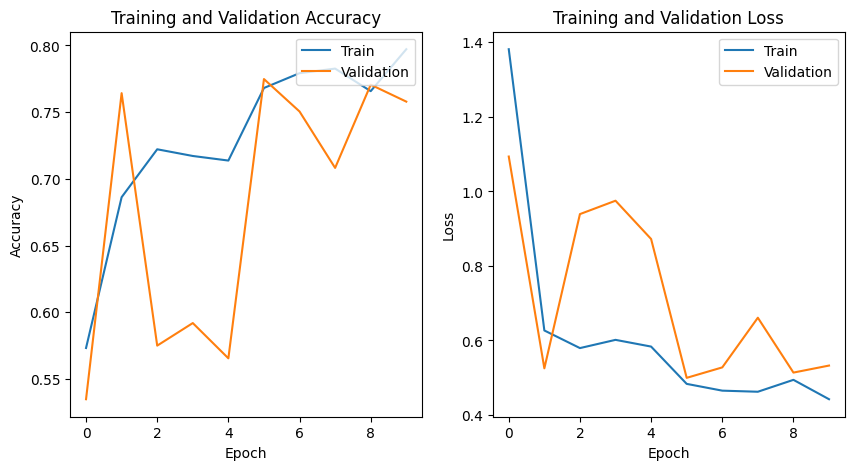

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mlp3.history['accuracy'])
plt.plot(history_mlp3.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp3.history['loss'])
plt.plot(history_mlp3.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_mlp3.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 6s 146ms/step - loss: 0.5200 - accuracy: 0.7694
Test Loss: 0.520004
Test Accuracy: 0.769426


Define the Fourth MLP model

In [ ]:
model_mlp4 = tf.keras.Sequential()
model_mlp4.add(layers.Flatten(input_shape=(128, 128, 3), name="input"))
model_mlp4.add(layers.Dense(256, activation='relu', name='hidden1'))
model_mlp4.add(layers.Dense(128, activation='relu', name='hidden2'))
model_mlp4.add(layers.Dense(64, activation='relu', name='hidden3'))
model_mlp4.add(layers.Dense(32, activation='relu', name='hidden4'))
model_mlp4.add(layers.Dense(16, activation='relu', name='hidden5'))
model_mlp4.add(layers.Dense(1, activation='sigmoid', name='output'))
model_mlp4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 49152)             0         
                                                                 
 hidden1 (Dense)             (None, 256)               12583168  
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 hidden3 (Dense)             (None, 64)                8256      
                                                                 
 hidden4 (Dense)             (None, 32)                2080      
                                                                 
 hidden5 (Dense)             (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                

Plotting the model schema

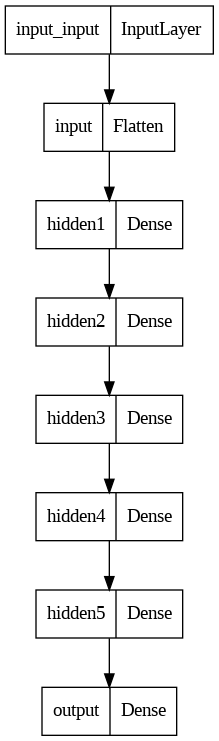

In [ ]:
keras.utils.plot_model(model_mlp4, 'model_mlp4.png')

Compile and fitting the model

In [ ]:
model_mlp4.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=['accuracy'])
history_mlp4 = model_mlp4.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 44s 346ms/step - loss: 1.1597 - accuracy: 0.5860 - val_loss: 1.0150 - val_accuracy: 0.5032
Epoch 2/10
119/119 [==============================] - 44s 358ms/step - loss: 0.7591 - accuracy: 0.6256 - val_loss: 0.5638 - val_accuracy: 0.7188
Epoch 3/10
119/119 [==============================] - 44s 361ms/step - loss: 0.5867 - accuracy: 0.6913 - val_loss: 0.5529 - val_accuracy: 0.7421
Epoch 4/10
119/119 [==============================] - 44s 362ms/step - loss: 0.5874 - accuracy: 0.7021 - val_loss: 0.6414 - val_accuracy: 0.6871
Epoch 5/10
119/119 [==============================] - 42s 347ms/step - loss: 0.5715 - accuracy: 0.7064 - val_loss: 0.5808 - val_accuracy: 0.6934
Epoch 6/10
119/119 [==============================] - 42s 347ms/step - loss: 0.5286 - accuracy: 0.7296 - val_loss: 0.5237 - val_accuracy: 0.7463
Epoch 7/10
119/119 [==============================] - 44s 354ms/step - loss: 0.5141 - accuracy: 0.7499 - val_loss: 0.5133 - val_ac

Plotting the loss and the accuracy

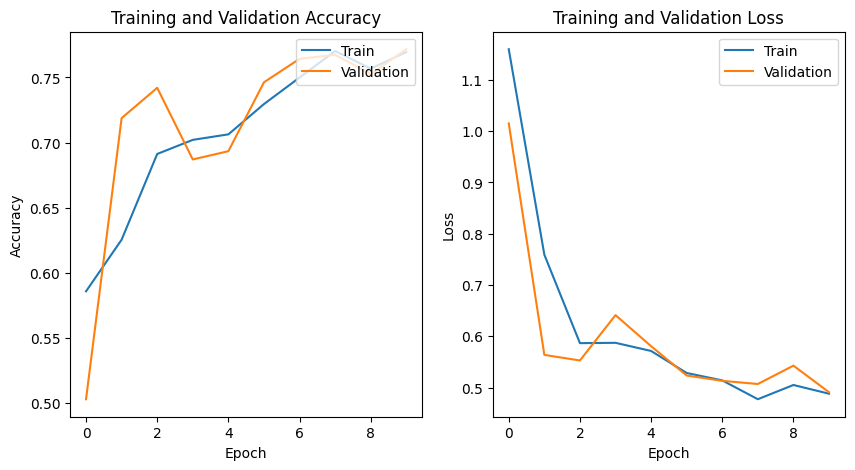

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mlp4.history['accuracy'])
plt.plot(history_mlp4.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp4.history['loss'])
plt.plot(history_mlp4.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_mlp4.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 5s 111ms/step - loss: 0.5056 - accuracy: 0.7669
Test Loss: 0.505556
Test Accuracy: 0.766892


### MLP with Hyperparameter Tuning

To Compute the MLP model with Hyperparameter Tuning I choose the best MLP model

Creating the multi-layer neural network model with Hyperparameter Tuning

In [ ]:
def building_model_mlp(hp):
  model_mlp4 = tf.keras.Sequential()

  model_mlp4.add(layers.Flatten(input_shape=(128, 128, 3), name="input"))
  model_mlp4.add(layers.Dense(256, activation='relu', name='hidden1'))
  model_mlp4.add(layers.Dense(128, activation='relu', name='hidden2'))
  model_mlp4.add(layers.Dense(64, activation='relu', name='hidden3'))
  model_mlp4.add(layers.Dense(32, activation='relu', name='hidden4'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

  model_mlp4.add(keras.layers.Dense(units=hp_units, activation='relu', name='hidden5'))
  model_mlp4.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model_mlp4.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model_mlp4

Fitting the model

Instanciate and excecute the hypertuning

In [ ]:
tuner_mlp = kt.Hyperband(building_model_mlp,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2)

Stop early the search of the hyperparameter tuning

In [ ]:
tuner_mlp.search_space_summary()
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Searching the right hyperparameter

In [ ]:
tuner_mlp.search(train_normalized, epochs=10, validation_data=val_normalized, callbacks=stop_early)

# Get the optimal hyperparameters
best_hps=tuner_mlp.get_best_hyperparameters(num_trials=1)[0]

print(f"""The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.""")

Trial 21 Complete [00h 02m 39s]
val_accuracy: 0.768498957157135

Best val_accuracy So Far: 0.7769556045532227
Total elapsed time: 00h 32m 46s
The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.001.


Run the model to find the best hyperparameters and epochs

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = tuner_mlp.hypermodel.build(best_hps)
history = model.fit(train_normalized, epochs=10, validation_data=val_normalized)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
119/119 [==============================] - 30s 241ms/step - loss: 0.7628 - accuracy: 0.5706 - val_loss: 0.7059 - val_accuracy: 0.4841
Epoch 2/10
119/119 [==============================] - 29s 240ms/step - loss: 0.6557 - accuracy: 0.6234 - val_loss: 0.5813 - val_accuracy: 0.7241
Epoch 3/10
119/119 [==============================] - 30s 246ms/step - loss: 0.5998 - accuracy: 0.6675 - val_loss: 0.5624 - val_accuracy: 0.7400
Epoch 4/10
119/119 [==============================] - 28s 224ms/step - loss: 0.5621 - accuracy: 0.7066 - val_loss: 0.5420 - val_accuracy: 0.7347
Epoch 5/10
119/119 [==============================] - 28s 223ms/step - loss: 0.5391 - accuracy: 0.7317 - val_loss: 0.5677 - val_accuracy: 0.7082
Epoch 6/10
119/119 [==============================] - 29s 238ms/step - loss: 0.5111 - accuracy: 0.7505 - val_loss: 0.5180 - val_accuracy: 0.7622
Epoch 7/10
119/119 [==============================] - 29s 238ms/step - loss: 0.5095 - accuracy: 0.7547 - val_loss: 0.5298 - val_ac

Rerun the model with the optimal value for the epoch

In [ ]:
hypermodel_mlp = tuner_mlp.hypermodel.build(best_hps)

# Retrain the model
history_mlp = hypermodel_mlp.fit(train_normalized, epochs=best_epoch, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 30s 232ms/step - loss: 0.8917 - accuracy: 0.5572 - val_loss: 0.6691 - val_accuracy: 0.5740
Epoch 2/10
119/119 [==============================] - 28s 227ms/step - loss: 0.6339 - accuracy: 0.6382 - val_loss: 0.5695 - val_accuracy: 0.7114
Epoch 3/10
119/119 [==============================] - 33s 271ms/step - loss: 0.5856 - accuracy: 0.6855 - val_loss: 0.8017 - val_accuracy: 0.6237
Epoch 4/10
119/119 [==============================] - 29s 235ms/step - loss: 0.5848 - accuracy: 0.6897 - val_loss: 0.5347 - val_accuracy: 0.7569
Epoch 5/10
119/119 [==============================] - 29s 231ms/step - loss: 0.5029 - accuracy: 0.7592 - val_loss: 0.6876 - val_accuracy: 0.6839
Epoch 6/10
119/119 [==============================] - 30s 241ms/step - loss: 0.5019 - accuracy: 0.7555 - val_loss: 0.6026 - val_accuracy: 0.7008
Epoch 7/10
119/119 [==============================] - 30s 244ms/step - loss: 0.4958 - accuracy: 0.7637 - val_loss: 0.5210 - val_ac

Evaluate the hypermodel

In [ ]:
test_loss, test_accuracy = hypermodel_mlp.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 7s 162ms/step - loss: 0.4846 - accuracy: 0.7829
Test Loss: 0.484637
Test Accuracy: 0.782939


Plotting the MLP hypermodel for the accuracy and for the loss

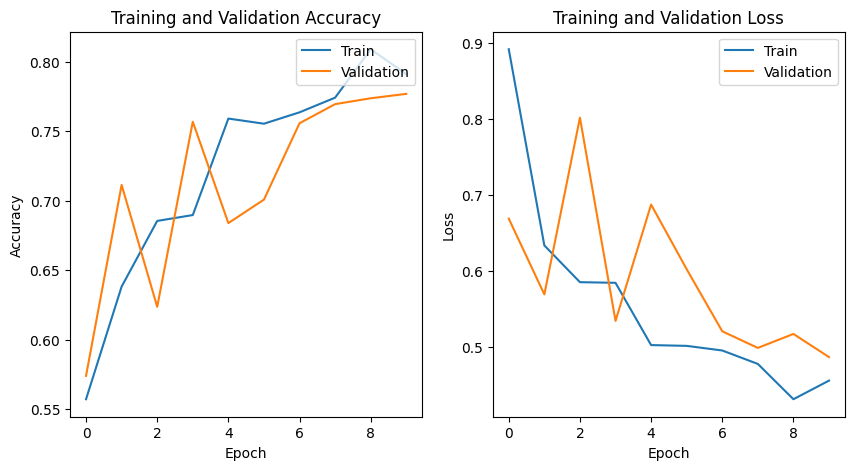

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Convolutional Neural Network (CNN)

Define the First CNN model

In [ ]:
model_cnn1 = models.Sequential()
model_cnn1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), name='convolution'))
model_cnn1.add(layers.MaxPooling2D((2, 2), name='pooling'))
model_cnn1.add(Dropout(rate=0.2, name="dropout"))
model_cnn1.add(layers.Flatten(name='flatten'))
model_cnn1.add(layers.Dense(128, activation='relu', name='layer'))
model_cnn1.add(keras.layers.Dense(1, activation='sigmoid', name='output'))
model_cnn1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution (Conv2D)        (None, 126, 126, 32)      896       
                                                                 
 pooling (MaxPooling2D)      (None, 63, 63, 32)        0         
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 layer (Dense)               (None, 128)               16257152  
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 16,258,177
Trainable params: 16,258,177


Plotting the schema of the model

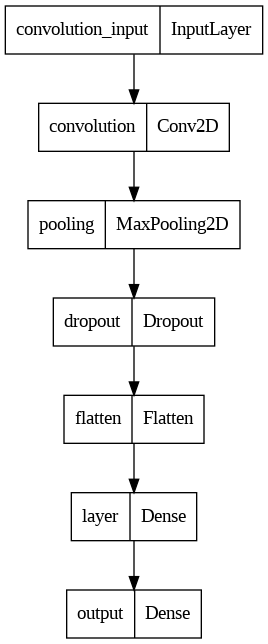

In [ ]:
keras.utils.plot_model(model_cnn1, 'model_cnn1.png')

Fitting and Compile the CNN model

In [ ]:
model_cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn1 = model_cnn1.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 150s 888ms/step - loss: 0.8074 - accuracy: 0.7671 - val_loss: 0.3720 - val_accuracy: 0.8457
Epoch 2/10
119/119 [==============================] - 102s 847ms/step - loss: 0.2753 - accuracy: 0.8949 - val_loss: 0.6576 - val_accuracy: 0.7600
Epoch 3/10
119/119 [==============================] - 101s 836ms/step - loss: 0.1831 - accuracy: 0.9366 - val_loss: 0.3985 - val_accuracy: 0.8510
Epoch 4/10
119/119 [==============================] - 102s 840ms/step - loss: 0.1030 - accuracy: 0.9657 - val_loss: 0.3914 - val_accuracy: 0.8605
Epoch 5/10
119/119 [==============================] - 113s 936ms/step - loss: 0.0649 - accuracy: 0.9823 - val_loss: 0.3796 - val_accuracy: 0.8721
Epoch 6/10
119/119 [==============================] - 103s 852ms/step - loss: 0.0384 - accuracy: 0.9926 - val_loss: 0.4508 - val_accuracy: 0.8615
Epoch 7/10
119/119 [==============================] - 106s 881ms/step - loss: 0.0258 - accuracy: 0.9958 - val_loss: 0.4278 -

Plotting the model

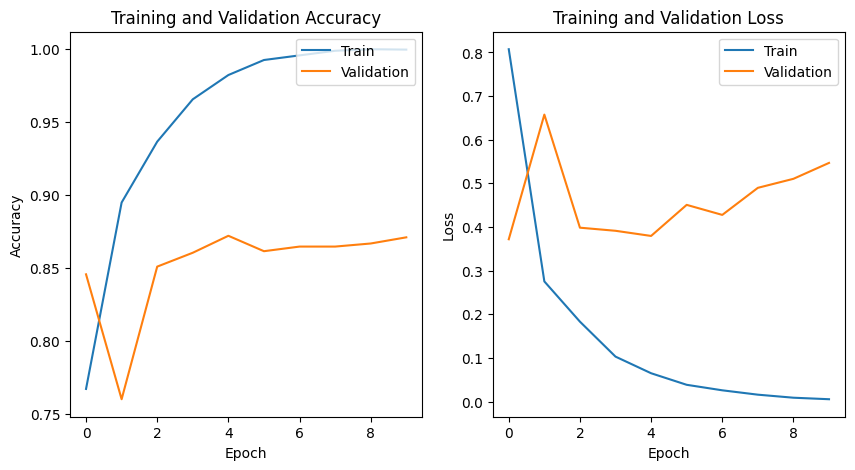

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn1.history['accuracy'])
plt.plot(history_cnn1.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn1.history['loss'])
plt.plot(history_cnn1.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_cnn1.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 10s 251ms/step - loss: 0.5353 - accuracy: 0.8556
Test Loss: 0.535288
Test Accuracy: 0.855574


Define the Second CNN model

In [ ]:
model_cnn2 = models.Sequential()
model_cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), name='convolution1'))
model_cnn2.add(layers.MaxPooling2D((2, 2), name='pooling1'))
model_cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', name='convolution2'))
model_cnn2.add(layers.MaxPooling2D((2, 2), name='pooling2'))
model_cnn2.add(layers.Flatten(name='flatten'))
model_cnn2.add(layers.Dense(128, activation='relu', name='layer'))
model_cnn2.add(keras.layers.Dense(1, activation='sigmoid', name='output'))
model_cnn2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution1 (Conv2D)       (None, 126, 126, 32)      896       
                                                                 
 pooling1 (MaxPooling2D)     (None, 63, 63, 32)        0         
                                                                 
 convolution2 (Conv2D)       (None, 61, 61, 64)        18496     
                                                                 
 pooling2 (MaxPooling2D)     (None, 30, 30, 64)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 layer (Dense)               (None, 128)               7372928   
                                                                 
 output (Dense)              (None, 1)                

Plotting the schema of the model

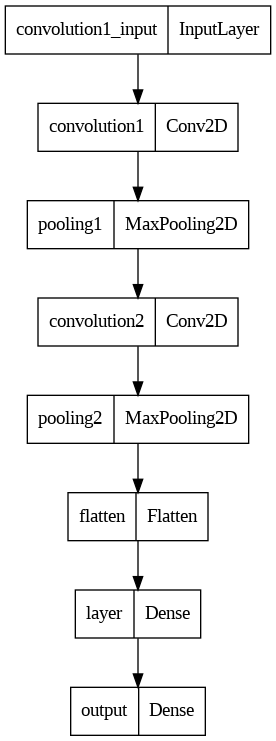

In [ ]:
keras.utils.plot_model(model_cnn2, 'model_cnn2.png')

Fitting and Compile the CNN model

In [ ]:
model_cnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn2 = model_cnn2.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 125s 1s/step - loss: 0.5798 - accuracy: 0.7338 - val_loss: 0.4071 - val_accuracy: 0.8362
Epoch 2/10
119/119 [==============================] - 124s 1s/step - loss: 0.3640 - accuracy: 0.8490 - val_loss: 0.4907 - val_accuracy: 0.7854
Epoch 3/10
119/119 [==============================] - 123s 1s/step - loss: 0.2572 - accuracy: 0.8912 - val_loss: 0.3360 - val_accuracy: 0.8721
Epoch 4/10
119/119 [==============================] - 122s 1s/step - loss: 0.1709 - accuracy: 0.9342 - val_loss: 0.3245 - val_accuracy: 0.8816
Epoch 5/10
119/119 [==============================] - 124s 1s/step - loss: 0.1090 - accuracy: 0.9620 - val_loss: 0.3389 - val_accuracy: 0.8774
Epoch 6/10
119/119 [==============================] - 123s 1s/step - loss: 0.0866 - accuracy: 0.9696 - val_loss: 0.4016 - val_accuracy: 0.8732
Epoch 7/10
119/119 [==============================] - 123s 1s/step - loss: 0.0423 - accuracy: 0.9892 - val_loss: 0.3827 - val_accuracy: 0.8911

Plotting the model

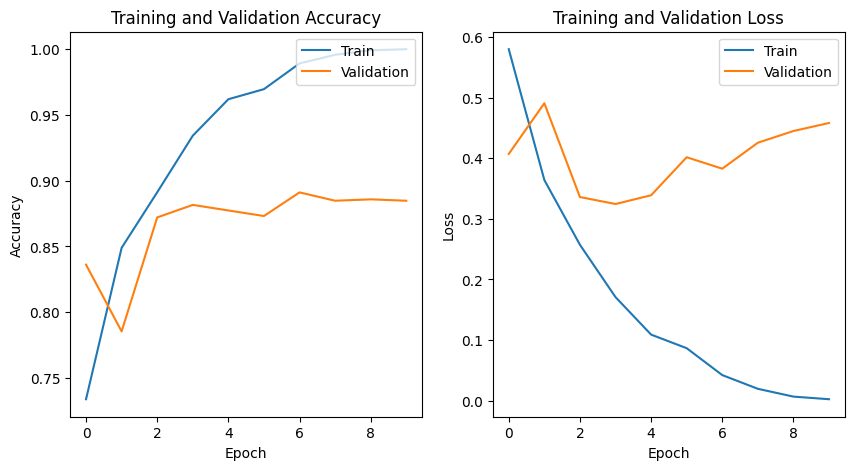

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['accuracy'])
plt.plot(history_cnn2.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_cnn2.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 13s 317ms/step - loss: 0.5039 - accuracy: 0.8877
Test Loss: 0.503913
Test Accuracy: 0.887669


Define the Third CNN model

In [ ]:
model_cnn3 = models.Sequential()
model_cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), name='convolution1'))
model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling1'))
model_cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', name='convolution2'))
model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling2'))
model_cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', name='convolution3'))
model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling3'))
model_cnn3.add(layers.Flatten(name='flatten'))
model_cnn3.add(layers.Dense(128, activation='relu', name='layer'))
model_cnn3.add(keras.layers.Dense(1, activation='sigmoid', name='output'))
model_cnn3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution1 (Conv2D)       (None, 126, 126, 32)      896       
                                                                 
 pooling1 (MaxPooling2D)     (None, 63, 63, 32)        0         
                                                                 
 convolution2 (Conv2D)       (None, 61, 61, 64)        18496     
                                                                 
 pooling2 (MaxPooling2D)     (None, 30, 30, 64)        0         
                                                                 
 convolution3 (Conv2D)       (None, 28, 28, 128)       73856     
                                                                 
 pooling3 (MaxPooling2D)     (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)           

Plotting the schema of the model

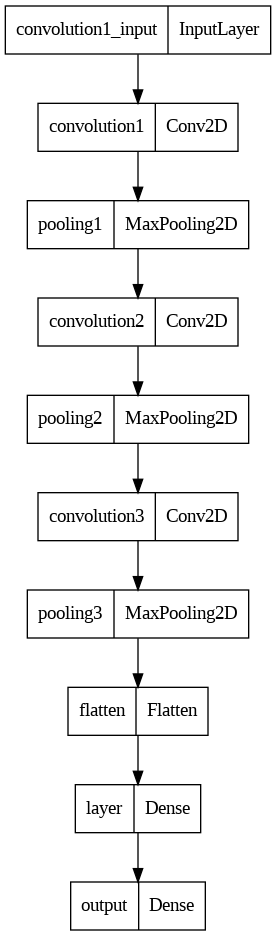

In [ ]:
keras.utils.plot_model(model_cnn3, 'model_cnn3.png')

Fitting and Compile the CNN model

In [ ]:
model_cnn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn3 = model_cnn3.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 158s 1s/step - loss: 0.5810 - accuracy: 0.6884 - val_loss: 0.4470 - val_accuracy: 0.8087
Epoch 2/10
119/119 [==============================] - 157s 1s/step - loss: 0.4108 - accuracy: 0.8175 - val_loss: 0.4113 - val_accuracy: 0.8224
Epoch 3/10
119/119 [==============================] - 157s 1s/step - loss: 0.3124 - accuracy: 0.8608 - val_loss: 0.3090 - val_accuracy: 0.8732
Epoch 4/10
119/119 [==============================] - 159s 1s/step - loss: 0.2626 - accuracy: 0.8912 - val_loss: 0.3023 - val_accuracy: 0.8795
Epoch 5/10
119/119 [==============================] - 150s 1s/step - loss: 0.2082 - accuracy: 0.9105 - val_loss: 0.3548 - val_accuracy: 0.8626
Epoch 6/10
119/119 [==============================] - 156s 1s/step - loss: 0.1729 - accuracy: 0.9319 - val_loss: 0.3510 - val_accuracy: 0.8763
Epoch 7/10
119/119 [==============================] - 154s 1s/step - loss: 0.1345 - accuracy: 0.9401 - val_loss: 0.3604 - val_accuracy: 0.8805

Plotting the model

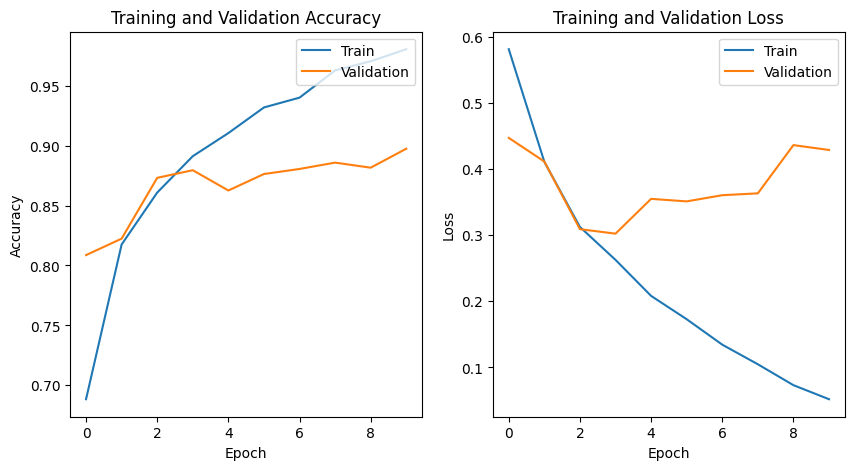

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn3.history['accuracy'])
plt.plot(history_cnn3.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn3.history['loss'])
plt.plot(history_cnn3.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [ ]:
test_loss, test_accuracy = model_cnn3.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 15s 366ms/step - loss: 0.4551 - accuracy: 0.8894
Test Loss: 0.455143
Test Accuracy: 0.889358


### CNN with Hyperparameter Tuning

Creating the convolutional neural network model with Hyperparameter Tuning

In [ ]:
def building_model_cnn(hp):
  model_cnn3 = tf.keras.Sequential()

  model_cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), name='convolution1'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling1'))
  model_cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', name='convolution2'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling2'))
  model_cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', name='convolution3'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling3'))

  model_cnn3.add(keras.layers.Flatten(name='flatten'))

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

  model_cnn3.add(keras.layers.Dense(units=hp_units, activation='relu', name='hidden'))
  model_cnn3.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model_cnn3.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model_cnn3

Fitting the model

Instanciate and excecute the hypertuning

In [ ]:
tuner_cnn = kt.Hyperband(building_model_cnn,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2)

Stop early the search of the hyperparameter tuning

In [ ]:
tuner_cnn.search_space_summary()
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Searching the right hyperparameter

In [ ]:
tuner_cnn.search(train_normalized, epochs=10, validation_data=val_normalized, callbacks=stop_early)

# Get the optimal hyperparameters
best_hps=tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

print(f"""The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.""")

The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.001.


Run the model to find the best hyperparameters and epochs

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = tuner_cnn.hypermodel.build(best_hps)
history = model.fit(train_normalized, epochs=10, validation_data=val_normalized)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
119/119 [==============================] - 179s 1s/step - loss: 0.4908 - accuracy: 0.7705 - val_loss: 0.4523 - val_accuracy: 0.8150
Epoch 2/10
119/119 [==============================] - 169s 1s/step - loss: 0.3498 - accuracy: 0.8500 - val_loss: 0.4328 - val_accuracy: 0.8214
Epoch 3/10
119/119 [==============================] - 170s 1s/step - loss: 0.2673 - accuracy: 0.8912 - val_loss: 0.2831 - val_accuracy: 0.8911
Epoch 4/10
119/119 [==============================] - 172s 1s/step - loss: 0.2182 - accuracy: 0.9121 - val_loss: 0.3407 - val_accuracy: 0.8763
Epoch 5/10
119/119 [==============================] - 170s 1s/step - loss: 0.1601 - accuracy: 0.9372 - val_loss: 0.2856 - val_accuracy: 0.9017
Epoch 6/10
119/119 [==============================] - 169s 1s/step - loss: 0.1116 - accuracy: 0.9585 - val_loss: 0.3050 - val_accuracy: 0.9080
Epoch 7/10
119/119 [==============================] - 159s 1s/step - loss: 0.0875 - accuracy: 0.9659 - val_loss: 0.3484 - val_accuracy: 0.9101

Rerun the model with the optimal value for the epoch

In [ ]:
hypermodel_cnn = tuner_cnn.hypermodel.build(best_hps)

# Retrain the model
history_cnn = hypermodel_cnn.fit(train_normalized, epochs=best_epoch, validation_data=val_normalized)

Epoch 1/7
119/119 [==============================] - 168s 1s/step - loss: 0.5247 - accuracy: 0.7460 - val_loss: 0.4051 - val_accuracy: 0.8214
Epoch 2/7
119/119 [==============================] - 168s 1s/step - loss: 0.3659 - accuracy: 0.8397 - val_loss: 0.3577 - val_accuracy: 0.8457
Epoch 3/7
119/119 [==============================] - 168s 1s/step - loss: 0.3346 - accuracy: 0.8540 - val_loss: 0.3835 - val_accuracy: 0.8467
Epoch 4/7
119/119 [==============================] - 170s 1s/step - loss: 0.2596 - accuracy: 0.8857 - val_loss: 0.2952 - val_accuracy: 0.8922
Epoch 5/7
119/119 [==============================] - 168s 1s/step - loss: 0.1950 - accuracy: 0.9224 - val_loss: 0.3243 - val_accuracy: 0.8932
Epoch 6/7
119/119 [==============================] - 168s 1s/step - loss: 0.1555 - accuracy: 0.9424 - val_loss: 0.4605 - val_accuracy: 0.8615
Epoch 7/7
119/119 [==============================] - 168s 1s/step - loss: 0.1198 - accuracy: 0.9504 - val_loss: 0.3888 - val_accuracy: 0.8858


Evaluate the hypermodel

In [ ]:
test_loss, test_accuracy = hypermodel_cnn.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 16s 378ms/step - loss: 0.3645 - accuracy: 0.8750
Test Loss: 0.364465
Test Accuracy: 0.875000


Plotting the CNN model for the accuracy and for the loss

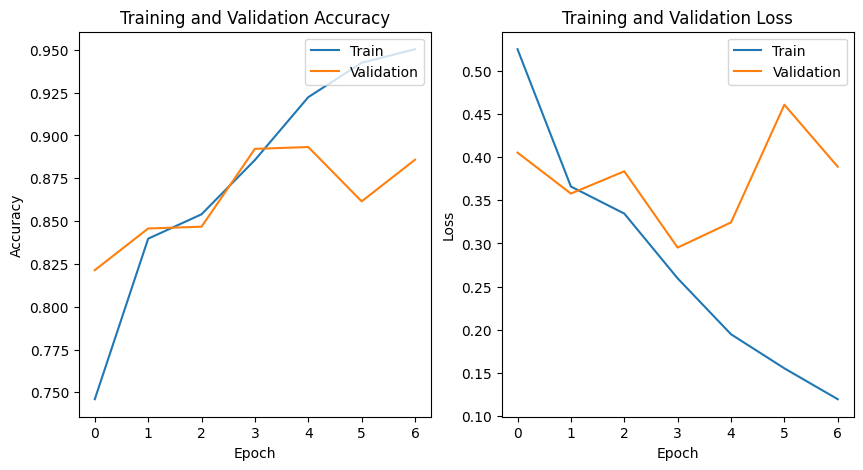

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Residual Neural Network (ResNet)

Upload of the pre-trained ResNet50 model

In [18]:
model_resNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
model_resNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [20]:
for layer in model_resNet50.layers:
    layer.trainable = False

Creating the residual neural network model

In [24]:
x = model_resNet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_resNet = keras.Model(inputs = model_resNet50.input, outputs=predictions)

model_resNet.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

Fitting the model

In [25]:
# Train the model
history_resNet = model_resNet.fit(train_normalized, epochs=10, validation_data=val_normalized)

Epoch 1/10
119/119 [==============================] - 296s 2s/step - loss: 0.6188 - accuracy: 0.6760 - val_loss: 0.5752 - val_accuracy: 0.6776
Epoch 2/10
119/119 [==============================] - 293s 2s/step - loss: 0.5290 - accuracy: 0.7465 - val_loss: 0.5013 - val_accuracy: 0.7801
Epoch 3/10
119/119 [==============================] - 295s 2s/step - loss: 0.4886 - accuracy: 0.7716 - val_loss: 0.4709 - val_accuracy: 0.8044
Epoch 4/10
119/119 [==============================] - 298s 2s/step - loss: 0.4711 - accuracy: 0.7761 - val_loss: 0.4828 - val_accuracy: 0.7600
Epoch 5/10
119/119 [==============================] - 295s 2s/step - loss: 0.4602 - accuracy: 0.7840 - val_loss: 0.4363 - val_accuracy: 0.8235
Epoch 6/10
119/119 [==============================] - 266s 2s/step - loss: 0.4309 - accuracy: 0.8057 - val_loss: 0.4408 - val_accuracy: 0.8140
Epoch 7/10
119/119 [==============================] - 297s 2s/step - loss: 0.4213 - accuracy: 0.8049 - val_loss: 0.4173 - val_accuracy: 0.8266

Evaluate the model

In [26]:
test_loss, test_accuracy = model_resNet.evaluate(test_normalized)
print("Test Loss: %f" % test_loss)
print("Test Accuracy: %f" % test_accuracy)

37/37 [==============================] - 69s 2s/step - loss: 0.4667 - accuracy: 0.7711
Test Loss: 0.466725
Test Accuracy: 0.771115


Plotting the ResNet model for the accuracy and for the loss

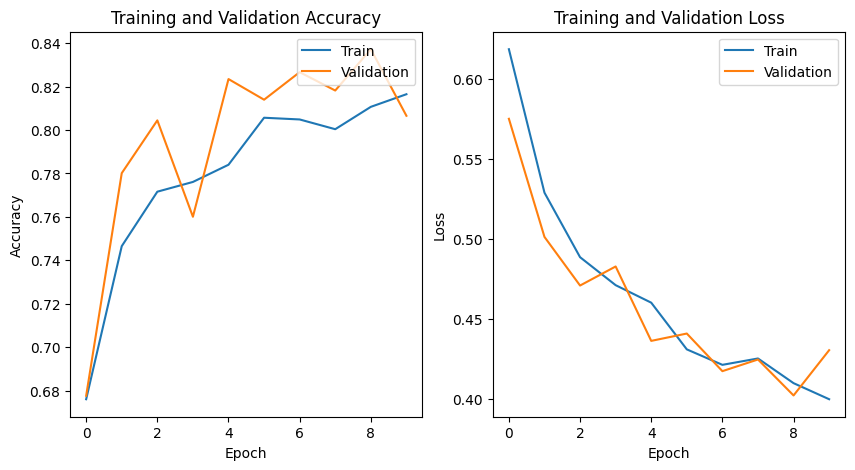

In [27]:
plt.figure(figsize=(10, 5))

# Plotting history for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resNet.history['accuracy'])
plt.plot(history_resNet.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting history for Loss
plt.subplot(1, 2, 2)
plt.plot(history_resNet.history['loss'])
plt.plot(history_resNet.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## 5-fold cross validation

In [9]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    seed=100,
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(128,128)
)

Found 4733 files belonging to 2 classes.


In [10]:
# Dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [31]:
k_fold = 5
accuracy_fold = []
loss_fold = []
len_ds = len(train_dataset) // k_fold

In [46]:
def model_5K_CV(training, validation, k):

  model_cnn3 = models.Sequential()
  model_cnn3.add(layers.Rescaling(1./255))
  model_cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), name='convolution1'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling1'))
  model_cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', name='convolution2'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling2'))
  model_cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', name='convolution3'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling3'))
  model_cnn3.add(layers.Flatten(name='flatten'))
  model_cnn3.add(layers.Dense(128, activation='relu', name='layer'))
  model_cnn3.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

  model_cnn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  print("Training the model for " + str(k+1) + "-fold:")
  history = model_cnn3.fit(training, epochs=5, validation_data=validation)

  print("Evaluating the model: ")
  loss, accuracy = model_cnn3.evaluate(validation)

  loss_fold.append(loss)
  accuracy_fold.append(accuracy)

In [47]:
for i in range(k_fold):

    train1 = train_dataset.take(i*len_ds)
    validation = train_dataset.skip(i*len_ds).take(len_ds)
    train2 = train_dataset.skip(i*len_ds + len_ds)

    training = train2.concatenate(train1)

    model_5K_CV(training, validation, i)

Training the model for 1-fold:
Epoch 1/5
119/119 [==============================] - 203s 1s/step - loss: 0.5447 - accuracy: 0.7293 - val_loss: 0.5120 - val_accuracy: 0.7629
Epoch 2/5
119/119 [==============================] - 174s 1s/step - loss: 0.4007 - accuracy: 0.8302 - val_loss: 0.3369 - val_accuracy: 0.8567
Epoch 3/5
119/119 [==============================] - 176s 1s/step - loss: 0.3103 - accuracy: 0.8699 - val_loss: 0.3873 - val_accuracy: 0.8502
Epoch 4/5
119/119 [==============================] - 171s 1s/step - loss: 0.2726 - accuracy: 0.8854 - val_loss: 0.3158 - val_accuracy: 0.8631
Epoch 5/5
119/119 [==============================] - 175s 1s/step - loss: 0.2222 - accuracy: 0.9078 - val_loss: 0.3429 - val_accuracy: 0.8793
Evaluating the model: 
29/29 [==============================] - 16s 500ms/step - loss: 0.3462 - accuracy: 0.8772
Training the model for 2-fold:
Epoch 1/5
119/119 [==============================] - 185s 1s/step - loss: 0.5426 - accuracy: 0.7335 - val_loss: 0.3

In [62]:
print("Loss 5-fold CV: " + str(loss_fold))
print("Accuracy 5-fold CV: " + str(accuracy_fold))

Loss 5-fold CV: [0.346177339553833, 0.23516850173473358, 0.2372964769601822, 0.2528984844684601, 0.35883235931396484]
Accuracy 5-fold CV: [0.8771551847457886, 0.9094827771186829, 0.9148706793785095, 0.9019396305084229, 0.8523706793785095]


In [10]:
print("Average loss: %f" % np.mean(loss_fold))
print("Average accuracy: %f" % np.mean(accuracy_fold))

Average loss: 0.286075
Average accuracy: 0.891164


## 5-fold cross validation with Hyperparameter Tuning

In [11]:
k_fold = 5
accuracy_fold = []
loss_fold = []
len_ds = len(train_dataset) // k_fold

In [18]:
def model_5K_CV_hp(training, validation, k):

  model_cnn3 = models.Sequential()
  model_cnn3.add(layers.Rescaling(1./255))
  model_cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), name='convolution1'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling1'))
  model_cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', name='convolution2'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling2'))
  model_cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', name='convolution3'))
  model_cnn3.add(layers.MaxPooling2D((2, 2), name='pooling3'))
  model_cnn3.add(layers.Flatten(name='flatten'))

  #The best hp_units computed is 512
  model_cnn3.add(layers.Dense(512, activation='relu', name='layer'))
  model_cnn3.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

  #The best learning rate computed is 0.001
  model_cnn3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

  #The best number of epochs computed is 7
  print("Training the model for " + str(k+1) + "-fold:")
  history = model_cnn3.fit(training, epochs=7, validation_data=validation)

  print("Evaluating the model: ")
  loss, accuracy = model_cnn3.evaluate(validation)

  loss_fold.append(loss)
  accuracy_fold.append(accuracy)

In [19]:
for i in range(k_fold):

    train1 = train_dataset.take(i*len_ds)
    validation = train_dataset.skip(i*len_ds).take(len_ds)
    train2 = train_dataset.skip(i*len_ds + len_ds)

    training = train2.concatenate(train1)

    model_5K_CV_hp(training, validation, i)

Training the model for 1-fold:
Epoch 1/7
119/119 [==============================] - 191s 2s/step - loss: 0.5274 - accuracy: 0.7466 - val_loss: 0.5246 - val_accuracy: 0.7295
Epoch 2/7
119/119 [==============================] - 187s 2s/step - loss: 0.3764 - accuracy: 0.8373 - val_loss: 0.3479 - val_accuracy: 0.8653
Epoch 3/7
119/119 [==============================] - 180s 1s/step - loss: 0.2924 - accuracy: 0.8794 - val_loss: 0.3323 - val_accuracy: 0.8448
Epoch 4/7
119/119 [==============================] - 177s 1s/step - loss: 0.2299 - accuracy: 0.9057 - val_loss: 0.3095 - val_accuracy: 0.8664
Epoch 5/7
119/119 [==============================] - 184s 2s/step - loss: 0.2142 - accuracy: 0.9146 - val_loss: 0.2729 - val_accuracy: 0.8847
Epoch 6/7
119/119 [==============================] - 179s 1s/step - loss: 0.1717 - accuracy: 0.9325 - val_loss: 0.2956 - val_accuracy: 0.8922
Epoch 7/7
119/119 [==============================] - 181s 1s/step - loss: 0.1073 - accuracy: 0.9598 - val_loss: 0.364

In [20]:
print("Loss 5-fold CV: " + str(loss_fold))
print("Accuracy 5-fold CV: " + str(accuracy_fold))

Loss 5-fold CV: [0.3936617374420166, 0.3360846936702728, 0.1942347288131714, 0.25709766149520874, 0.31388625502586365]
Accuracy 5-fold CV: [0.8717672228813171, 0.8534482717514038, 0.9256465435028076, 0.9084051847457886, 0.892241358757019]


In [12]:
print("Average loss: %f" % np.mean(loss_fold))
print("Average accuracy: %f" % np.mean(accuracy_fold))

Average loss: 0.298993
Average accuracy: 0.890302
